# Графическое представление информации

In [50]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [51]:
os.makedirs("../outputs/figures", exist_ok=True)
df = pd.read_csv("../outputs/data/processed/df_clean.csv")
print(df.shape)
df.head()

(3892, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


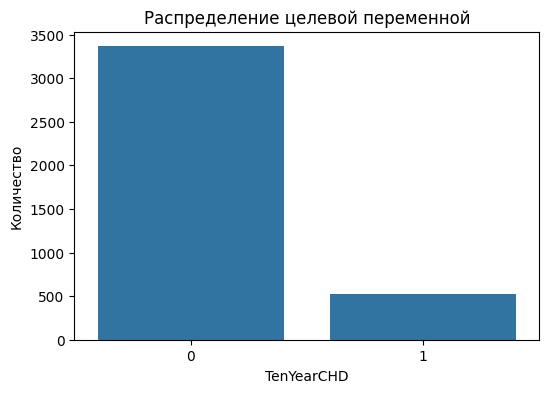

In [52]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="TenYearCHD")
plt.title("Распределение целевой переменной")
plt.xlabel("TenYearCHD")
plt.ylabel("Количество")
plt.savefig("../outputs/figures/01_TenYearCHD_count.png")
plt.show()

### 1: Исследование влияния курения на риск развития ишемической болезни сердца

**Нулевая гипотеза (H0):**
Курение (`currentSmoker`) и интенсивность курения (`cigsPerDay`) не связаны с риском развития ИБС (`TenYearCHD`)

**Альтернативная гипотеза (H1):**  
Курение и большее количество сигарет в день статистически значимо повышают вероятность возникновения ИБС

**Целевая переменная:** `TenYearCHD` (бинарная: 0/1)
**Предикторы:**
- `currentSmoker`: 1 — участник в настоящее время курит, 0 — участник в настоящее время не курит
- `cigsPerDay`: количество выкуриваемых сигарет в день

### 2: Исследование влияния холестерина и артериального давления на риск ИБС 

**Нулевая гипотеза (H0):**  
Уровень холестерина (`totChol`) и показатели артериального давления (`sysBP`, `diaBP`) не связаны с риском развития ишемической болезни сердца (`TenYearCHD`).

**Альтернативная гипотеза (H1):**  
Повышенные значения `totChol`, `sysBP` и `diaBP` статистически значимо коррелируют с вероятностью возникновения ИБС.

**Целевая переменная:** `TenYearCHD` (бинарная: 0/1)
**Предикторы:**
- `totChol`: общий холестерин (мг/дл)
- `sysBP`: систолическое артериальное давление (мм рт.ст.)
- `diaBP`: диастолическое артериальное давление (мм рт.ст.)

In [56]:
results = []

for col in ['totChol', 'sysBP', 'diaBP']:
    group_0 = df[df['TenYearCHD'] == 0][col]
    group_1 = df[df['TenYearCHD'] == 1][col]

    stat, p = stats.mannwhitneyu(group_0, group_1)

    d = (2 * stat) / (len(group_0) * len(group_1)) - 1
    effect_size = "малый" if abs(d) < 0.15 else "средний" if abs(d) < 0.30 else "большой"

    if p < 0.0001:
        p_formatted = "<0.0001"
    else:
        p_formatted = f"{p:.4f}"

    results.append({
        'Параметр': col,
        'U-критерий': f"{stat:.3f}",
        'p-value': p_formatted,
        'Размер эффекта': f'{d:.3f}: ({effect_size})'
    })

results_df = pd.DataFrame(results)
results_df

,Параметр,U-критерий,p-value,Размер эффекта
0,totChol,781588.500,<0.0001,-0.119: (малый)
1,sysBP,640515.500,<0.0001,-0.278: (средний)
2,diaBP,728586.500,<0.0001,-0.178: (средний)


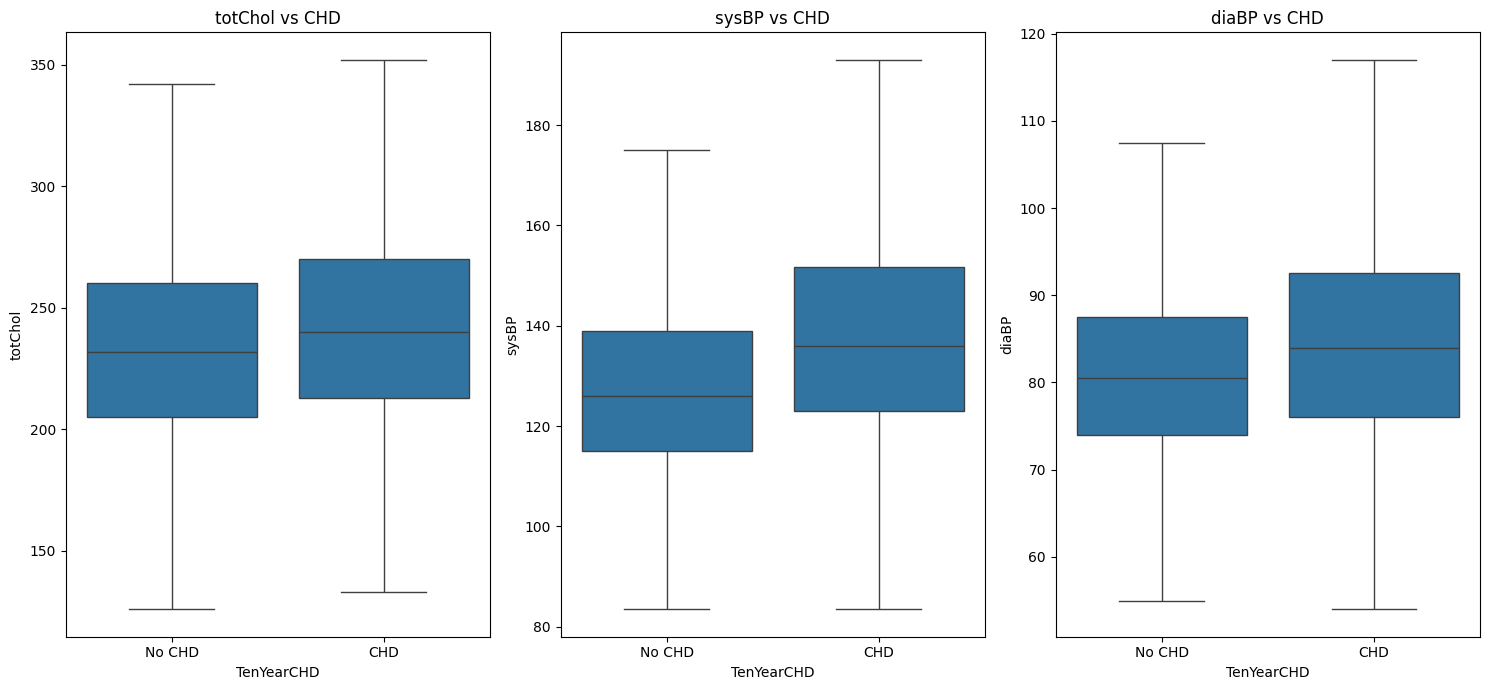

In [57]:
plt.figure(figsize=(15, 7))

for i, col in enumerate(['totChol', 'sysBP', 'diaBP'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='TenYearCHD', y=col, data=df, showfliers=False)
    plt.title(f"{col} vs CHD")
    plt.xticks([0,1], ["No CHD","CHD"])
    plt.savefig("../outputs/figures/04_ThreeParams_vs_CHD.png", bbox_inches="tight")
plt.tight_layout()


In [58]:
thresholds = {
    'sysBP': 140,  # Гипертония 1 стадии
    'diaBP': 90,   # Гипертония 1 стадии
    'totChol': 240 # Высокий холестерин (NCEP ATP III)
}

for param, threshold in thresholds.items():
    df[f'{param}_high'] = (df[param] >= threshold).astype(int)

threshold_results = []
for param in thresholds:
    crosstab = pd.crosstab(df[f'{param}_high'], df['TenYearCHD'], margins=False)
    a = crosstab.loc[1, 1]  # Высокий + ИБС
    b = crosstab.loc[1, 0]  # Высокий без ИБС
    c = crosstab.loc[0, 1]  # Нормальный + ИБС
    d = crosstab.loc[0, 0]  # Нормальный без ИБС

    prev_high = a / (a+b) * 100
    prev_normal = c / (c+d) * 100

    threshold_results.append({
        'Параметр': param,
        'Порог': thresholds[param],
        'ИБС при высоких значениях': f"{prev_high:.1f}%",
        'ИБС при нормальных значениях': f"{prev_normal:.1f}%",
        'Разница': f"{(prev_high - prev_normal):.1f}%"
    })

threshold_df = pd.DataFrame(threshold_results)
threshold_df

,Параметр,Порог,ИБС при высоких значениях,ИБС при нормальных значениях,Разница
0,sysBP,140,21.7%,10.6%,11.2%
1,diaBP,90,21.1%,11.4%,9.7%
2,totChol,240,15.8%,11.8%,3.9%


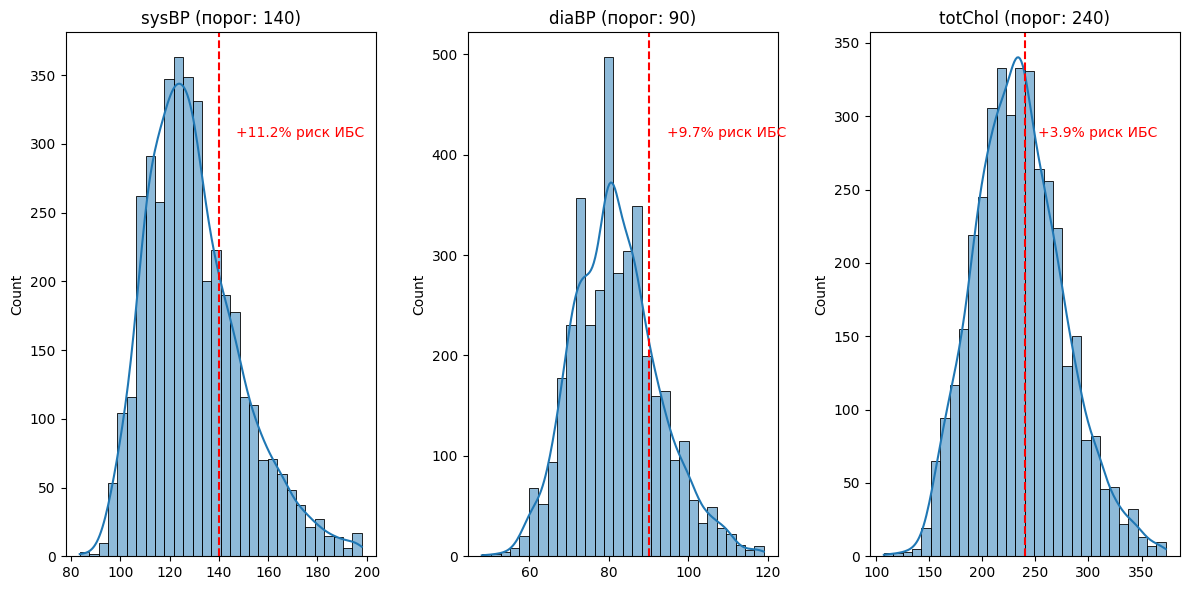

In [59]:
plt.figure(figsize=(12, 6))

for i, param in enumerate(thresholds, 1):
    plt.subplot(1, 3, i)
    
    sns.histplot(df[param], bins=30, kde=True)
    plt.axvline(thresholds[param], color='red', linestyle='--')
    plt.title(f"{param} (порог: {thresholds[param]})")
    plt.xlabel("")
    
    risk_text = f"+{threshold_results[i-1]['Разница']} риск ИБС"
    plt.text(thresholds[param]*1.05, plt.ylim()[1]*0.8, 
             risk_text, color='red', fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/figures/05_threshold_effects.png", bbox_inches="tight")
plt.show()

#### **Полученные результаты**:
- Все три параметра (totChol, sysBP, diaBP) показали значимые различия между группами с ИБС и без ИБС
- Отрицательное направление эффекта указывает, что значения параметров выше у пациентов с ИБС

Так же было проведено исследование с пороговыми значениями, где так же выявлена зависимость между данными:
- При sysBP ≥ 140 мм рт.ст. риск ИБС возрастает на +11.2% (21.7% vs 10.6%)
- При diaBP ≥ 90 мм рт.ст. разница составляет +9.7% (21.1% vs 11.4%)
- Для totChol ≥ 240 мг/дл прирост риска минимален (+3.9%)

**Систолическое давление** - наиболее значимый фактор риска по полученным результатам:
- Максимальный размер эффекта (d = -0.278)
- Наибольший прирост риска при превышении порога (+11.2%)



### 3: Исследование зависимости риска развития ишемической болезни в зависимости от пола

**Нулевая гипотеза (H0):**
Пол человека (`male`) не связан с риском развития ИБС (`TenYearCHD`)

**Альтернативная гипотеза (H1):**  
У мужчин риск развития болезни сердца выше, чем у женщин

**Целевая переменная:** `TenYearCHD` (бинарная: 0/1)
**Предиктор:**
- `male`: 1 — участник мужчина, 0 — женщина

### 4: Исследование является ли ожирение фактором риска развития сердечной недостаточности

**Нулевая гипотеза (H0):**
Индекс массы тела (`BMI`) не связан с риском развития ИБС (`TenYearCHD`)

**Альтернативная гипотеза (H1):**  
Люди с ожирением более подвержены развитию сердечной недостаточности

**Целевая переменная:** `TenYearCHD` (бинарная: 0/1)
**Предиктор:**
- `BMI`: Индекс массы тела